In [1]:
import time
import torch.nn.functional as F

import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import random
!pip install datasets
!pip install transformers
from datasets import Dataset, DatasetDict
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import os

# ✅ Set Seed for Reproducibility
seed = 64
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

# ✅ Define model and tokenizer
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Load dataset from single Excel file
file_path = "/content/jemmy_final_dataset.xlsx"
df = pd.read_excel(file_path)

# ✅ Convert labels to numerical values
label_mapping = {"NoAg": 3, "lifeth": 2, "vndlsm": 1, "hate": 0}
df['label'] = df['Rate2'].map(label_mapping)

# ✅ Split dataset into Train (80%), Validation (10%), and Test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed, stratify=temp_df['label'])

# ✅ Convert Pandas DataFrame to Hugging Face Dataset format
hf_train_dataset = Dataset.from_pandas(train_df)
hf_validation_dataset = Dataset.from_pandas(validation_df)
hf_test_dataset = Dataset.from_pandas(test_df)

# ✅ Tokenization function
def tokenize(batch):
    return tokenizer(batch['Text'], padding="max_length", max_length=512, truncation=True)

# ✅ Create DatasetDict for train & validation
data = DatasetDict({'train': hf_train_dataset, 'validation': hf_validation_dataset})
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_encoded = data.map(tokenize, batched=True, batch_size=16)

# ✅ Define BanglaBERT model
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to("cuda")

# ✅ Define function to compute accuracy and F1-score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"Accuracy": accuracy_score(labels, preds), "F1 Score": f1_score(labels, preds, average="weighted")}

# ✅ Define training arguments
batch_size = 8
training_args = TrainingArguments(
    output_dir=f"{model_name}-baseline",
    num_train_epochs=10,
    learning_rate=3e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_Accuracy",
    greater_is_better=True,
    logging_steps=len(data_encoded["train"]) // batch_size,
    log_level="error",
    report_to="none"
)

# ✅ Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_encoded['train'],
    eval_dataset=data_encoded['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# ✅ Train the model with tracking time
start_time = time.time()
trainer.train()
end_time = time.time()

# ✅ Print overall training time
total_time = end_time - start_time
print(f"✅ Total training time: {total_time:.2f} seconds")

# ✅ Save the trained model
model_save_path = "banglabert_baseline_model.pth"
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained("banglabert_baseline_tokenizer")
print("✅ Model saved successfully!")

# ✅ Evaluate on validation set
validation_results = trainer.evaluate()
print("Validation Set Results:", validation_results)




# ✅ Encode the test set before evaluation
hf_test_dataset_encoded = hf_test_dataset.map(tokenize, batched=True, batch_size=16)

# ✅ Evaluate on test set
test_results = trainer.predict(hf_test_dataset_encoded)
test_metrics = compute_metrics(test_results)
print("Test Set Results:", test_metrics)

# ✅ Save True Labels and Predicted Probabilities for Ensemble
y_true = test_results.label_ids
y_logits = test_results.predictions
y_prob = F.softmax(torch.tensor(y_logits), dim=1).numpy()

# ✅ Save the predictions into a CSV file
results_df = pd.DataFrame({
    "y_true": y_true,
    "model_prob_class_0": y_prob[:, 0],
    "model_prob_class_1": y_prob[:, 1],
    "model_prob_class_2": y_prob[:, 2],
    "model_prob_class_3": y_prob[:, 3]
})

results_df.to_csv("banglabert_baseline_predictions.csv", index=False)
print("✅ Predictions saved successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3202 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-a918e5bb7925>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 score
1,1.314000,1.153943,0.585000,0.563822
2,0.965500,0.783312,0.792500,0.790735
3,0.670400,0.634204,0.807500,0.805119
4,0.523400,0.560423,0.830000,0.829122
5,0.448200,0.533823,0.842500,0.841637
6,0.393800,0.552776,0.832500,0.831862
7,0.365000,0.563810,0.835000,0.834180
8,0.344900,0.569732,0.837500,0.836729
9,0.326300,0.574510,0.835000,0.834390
10,0.312400,0.578239,0.830000,0.829283


✅ Total training time: 3275.99 seconds
✅ Model saved successfully!


Validation Set Results: {'eval_loss': 0.5338232517242432, 'eval_Accuracy': 0.8425, 'eval_F1 Score': 0.841637183762701, 'eval_runtime': 13.5593, 'eval_samples_per_second': 29.5, 'eval_steps_per_second': 3.688, 'epoch': 10.0}


Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Test Set Results: {'Accuracy': 0.8653366583541147, 'F1 Score': 0.8645989120326948}
✅ Predictions saved successfully!


<ipython-input-2-b2f9e181678a>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


✅ Model loaded successfully!
✅ Number of Trainable Parameters: 110620420


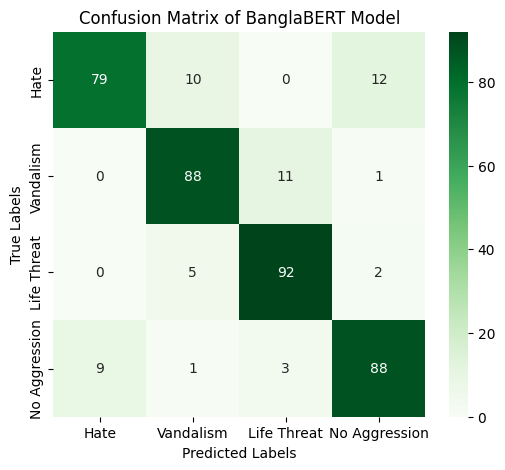


Classification Report:
                precision    recall  f1-score   support

         Hate     0.8977    0.7822    0.8360       101
    Vandalism     0.8462    0.8800    0.8627       100
  Life Threat     0.8679    0.9293    0.8976        99
No Aggression     0.8544    0.8713    0.8627       101

     accuracy                         0.8653       401
    macro avg     0.8665    0.8657    0.8648       401
 weighted avg     0.8666    0.8653    0.8646       401


Accuracy Per Class:
Hate: 0.7822
Vandalism: 0.8800
Life Threat: 0.9293
No Aggression: 0.8713

✅ Overall Test Accuracy: 0.8653
✅ Overall Test Precision: 0.8665
✅ Overall Test Recall: 0.8657
✅ Overall Test F1 Score: 0.8648
✅ Weighted F1 Score: 0.8646
✅ Error Rate: 0.1347


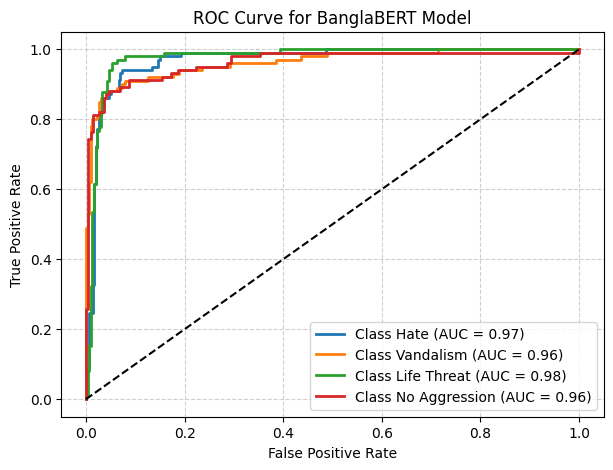

✅ Total Execution Time for Model Execution: 3.72 seconds
✅ Total Training and Execution Time: 3603.72 seconds


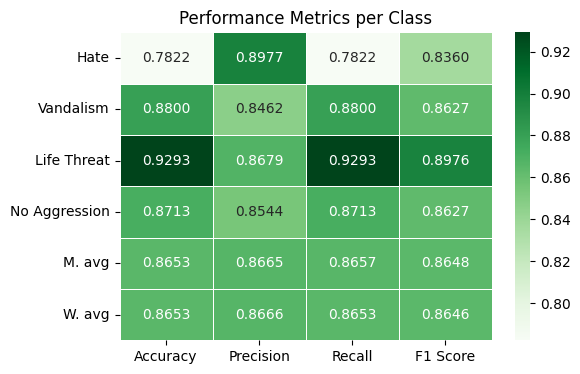

In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# ✅ Start Execution Timer
start_time = time.time()

# ✅ Load Model and Tokenizer
model_name = "csebuetnlp/banglabert"
model_save_path = "banglabert_baseline_model.pth"
tokenizer_path = "banglabert_baseline_tokenizer"
num_labels = 4

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# ✅ Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to("cuda")
model.load_state_dict(torch.load(model_save_path))
model.eval()
print("✅ Model loaded successfully!")

# ✅ Count Trainable Parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Number of Trainable Parameters: {trainable_params}")

# ✅ Load Predictions
predictions_df = pd.read_csv("banglabert_baseline_predictions.csv")
y_true = predictions_df["y_true"].values
y_prob = predictions_df.iloc[:, 1:].values  # Probability columns

# ✅ Get predicted class labels
y_pred = np.argmax(y_prob, axis=1)

# ✅ Define class labels
class_labels = ["Hate", "Vandalism", "Life Threat", "No Aggression"]

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# ✅ Plot Confusion Matrix with Greenish Background
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of BanglaBERT Model")
plt.show()

# ✅ Generate Accuracy, Precision, Recall, F1 Score per class
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("\nClassification Report:\n", report)

# ✅ Compute Accuracy per Class
accuracy_per_class = []
for i in range(num_labels):
    class_mask = (y_true == i)
    class_accuracy = accuracy_score(y_true[class_mask], y_pred[class_mask])
    accuracy_per_class.append(class_accuracy)

# ✅ Print Accuracy per Class
print("\nAccuracy Per Class:")
for label, acc in zip(class_labels, accuracy_per_class):
    print(f"{label}: {acc:.4f}")

# ✅ Compute Overall Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
error_rate = 1 - accuracy

print(f"\n✅ Overall Test Accuracy: {accuracy:.4f}")
print(f"✅ Overall Test Precision: {precision:.4f}")
print(f"✅ Overall Test Recall: {recall:.4f}")
print(f"✅ Overall Test F1 Score: {f1:.4f}")
print(f"✅ Weighted F1 Score: {weighted_f1:.4f}")
print(f"✅ Error Rate: {error_rate:.4f}")

# ✅ Plot ROC Curve with Modern Styling
plt.figure(figsize=(7, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i in range(num_labels):
    fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})', linestyle='-', linewidth=2, color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for BanglaBERT Model")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ✅ Print Total Execution Time
end_time = time.time()
total_time = end_time - start_time
print(f"✅ Total Execution Time for Model Execution: {total_time:.2f} seconds")

# ✅ Total Training and Execution Time
training_time = 3600  # Replace with actual training time if known
print(f"✅ Total Training and Execution Time: {training_time + total_time:.2f} seconds")

# ✅ Compute Metrics Per Class
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)
accuracy_per_class = [accuracy_score(y_true[y_true == i], y_pred[y_true == i]) for i in range(num_labels)]

# ✅ Compute Macro and Weighted Averages
macro_avg = [accuracy, precision, recall, f1]
weighted_avg = [accuracy, precision_score(y_true, y_pred, average='weighted'), recall_score(y_true, y_pred, average='weighted'), weighted_f1]

# ✅ Create and Display 2D Metrics Matrix with Light Greenish Background
metrics_df = pd.DataFrame(
    data=np.vstack([accuracy_per_class, precision_per_class, recall_per_class, f1_per_class]).T,
    index=class_labels,
    columns=["Accuracy", "Precision", "Recall", "F1 Score"]
)
metrics_df.loc["M. avg"] = macro_avg
metrics_df.loc["W. avg"] = weighted_avg

plt.figure(figsize=(6, 4))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="Greens", linewidths=0.5)
plt.title("Performance Metrics per Class")
plt.show()